In [0]:
import numpy as np
import random
from google.colab import drive
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import calinski_harabaz_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def read_file(fname, nidx=1):
    
    with open('/content/drive/My Drive/CMPE255/' + fname) as f:
        lines = f.readlines()
        
    nrows = len(lines)
    ncols = 0 
    nnz = 0 

    for i in range(nrows):
        p = lines[i].split()
        if len(p) % 2 != 0:
            raise ValueError("Invalid CSR matrix. Row %d contains %d numbers." % (i, len(p)))
        
        nnz += len(p)/2

        for j in range(0, len(p), 2): 
            col_id = int(p[j]) - nidx
            if col_id+1 > ncols:
                ncols = col_id + 1
    
    val = np.zeros(int(nnz), dtype=np.float)
    ind = np.zeros(int(nnz), dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in range(nrows):
        p = lines[i].split()
        for j in range(0, len(p), 2): 
            ind[n] = int(p[j]) - nidx
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n
    
    return csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)

In [0]:
def csr_idf(matrix, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        matrix = matrix.copy()
    nrows = matrix.shape[0]
    nnz = matrix.nnz
    ind, val, ptr = matrix.indices, matrix.data, matrix.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else matrix

In [0]:
def initialCentroids(matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    return matrixShuffled[:2,:]

In [0]:
def similarity(matrix, centroids):
    similarities = matrix.dot(centroids.T)
    return similarities

In [0]:
def findClusters(matrix, centroids):
    
    clusterA = list()
    clusterB = list()
    
    similarityMatrix = similarity(matrix, centroids)
    
    for index in range(similarityMatrix.shape[0]):
        similarityRow = similarityMatrix[index]
        
        #Sort the index of the matrix in ascending order of value and get the index of the last element
        #This index will be the cluster that the row in input matrix will belong to
        similaritySorted = np.argsort(similarityRow)[-1]
        
        if similaritySorted == 0:
            clusterA.append(index)
        else:
            clusterB.append(index)
        
    return clusterA, clusterB

In [0]:
def recalculateCentroid(matrix, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_array = np.asarray(centroids)
    
    return centroids_array

In [0]:
def kmeans(matrix, numberOfIterations):
    
    centroids = initialCentroids(matrix)
    
    for _ in range(numberOfIterations):
        
        clusters = list()
        
        clusterA, clusterB = findClusters(matrix, centroids)
        
        if len(clusterA) > 1:
            clusters.append(clusterA)
        if len(clusterB) > 1:
            clusters.append(clusterB)
            
        centroids = recalculateCentroid(matrix, clusters)
        
    return clusterA, clusterB

In [0]:
def calculateSSE(matrix, clusters):
    
    SSE_list = list()
    SSE_array = []
    
    for cluster in clusters:
        members = matrix[cluster,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        SSE_list.append(SSE)
        
    SSE_array = np.asarray(SSE_list)
    dropClusterIndex = np.argsort(SSE_array)[-1]
            
    return dropClusterIndex

In [0]:
def bisecting_kmeans(matrix, k, numberOfIterations):
    
    clusters = list()
    
    initialcluster = list()
    for i in range(matrix.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)
    
    while len(clusters) < k:

        dropClusterIndex = calculateSSE(matrix, clusters)
        droppedCluster = clusters[dropClusterIndex]
        
        clusterA, clusterB = kmeans(matrix[droppedCluster,:], numberOfIterations)
        del clusters[dropClusterIndex]
        
        actualClusterA = list()
        actualClusterB = list()
        for index in clusterA:
            actualClusterA.append(droppedCluster[index])
            
        for index in clusterB:
            actualClusterB.append(droppedCluster[index])
        
        clusters.append(actualClusterA)
        clusters.append(actualClusterB)
    
    labels = [0] * matrix.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [0]:
#Read CSR matrix from the input file
csrMatrix = read_file('train.dat', nidx=1)
# print(csrMatrix)
#Scale the CSR matrix by idf (Inverse Document Frequency)
csrIDF = csr_idf(csrMatrix, copy=True)
# print(csrIDF)
# print("\n\n=============\n\n")
# #Normalize the rows of a CSR matrix by their L-2 norm.
# csrL2Normalized = csr_l2normalize(csrIDF, copy=True)
# print(csrL2Normalized)
# #Obtain a dense ndarray representation of the CSR matrix.
# denseMatrix = csrIDF.toarray()
tsvd = TruncatedSVD(n_components=200)
denseMatrix = tsvd.fit_transform(csrIDF)

# print(denseMatrix)
# denseMatrix = csrIDF.toarray()

In [0]:
denseMatrix.shape

(8580, 200)

In [0]:
kValues = list()
scores = list()

for k in range(3, 22, 2):
    labels = bisecting_kmeans(denseMatrix, k, 10)
        # write result to output file
    if(k == 7):
        outputFile = open("/content/drive/My Drive/CMPE255/format.csv", "w+")
        outputFile.write("ItemID,ClusterID\n")
        for index in range(len(labels)):
            outputFile.write(str(index + 1) + "," + str(labels[index]) + '\n')
        outputFile.close()
    score = calinski_harabaz_score(denseMatrix, labels)
    kValues.append(k)
    scores.append(score)
    print ("For K= %d Calinski Harabaz Score is %f" %(k, score))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 3 Calinski Harabaz Score is 109.423152


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 5 Calinski Harabaz Score is 98.072289


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 7 Calinski Harabaz Score is 87.832870


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 9 Calinski Harabaz Score is 80.300835


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 11 Calinski Harabaz Score is 79.805075


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 13 Calinski Harabaz Score is 69.122543


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 15 Calinski Harabaz Score is 66.437620


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 17 Calinski Harabaz Score is 62.216180


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


For K= 19 Calinski Harabaz Score is 58.943918
For K= 21 Calinski Harabaz Score is 54.631798


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


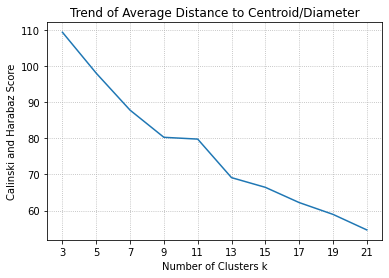

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(kValues, scores)
plt.xticks(kValues, kValues)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski and Harabaz Score')
plt.title('Trend of Average Distance to Centroid/Diameter')
plt.grid(linestyle='dotted')

plt.savefig('plot.png')
plt.show()